# Linear Regression

This post discusses on linear regression implementation in Python 3. 

Required libraries/packages:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
# Scikit-learn is imported only for dataset
from sklearn import datasets

The reason of choosing `statsmodels` is that `scipy.stats.linregress` is unable to handle multple linear regression. 

## Read Data

We use Boston housing dataset to conduct linear regression. It has 13 predictor variables (and 1 response variable) and 506 observations.

In [2]:
rawdt = datasets.load_boston()
df = pd.DataFrame(rawdt.data, columns=rawdt.feature_names)
df["Y"] = rawdt.target  # The response variable
df.shape

(506, 14)

A brief decription of the dataset:

- Number of Instances: 506 
- Number of Attributes: 13 numeric/categorical predictive
- Median Value (attribute 14) is usually the target
- Attribute Information (in order):
    - CRIM     per capita crime rate by town
    - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
    - INDUS    proportion of non-retail business acres per town
    - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    - NOX      nitric oxides concentration (parts per 10 million)
    - RM       average number of rooms per dwelling
    - AGE      proportion of owner-occupied units built prior to 1940
    - DIS      weighted distances to five Boston employment centres
    - RAD      index of accessibility to radial highways
    - TAX      full-value property-tax rate per \$10,000
    - PTRATIO   pupil-teacher ratio by town
    - B       1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - LSTAT     % lower status of the population
    - MEDV     Median value of owner-occupied homes in \$1000's

A quick view of all variables:

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Type of Each Variable

We need to draw scatterplot matrix for all variables:

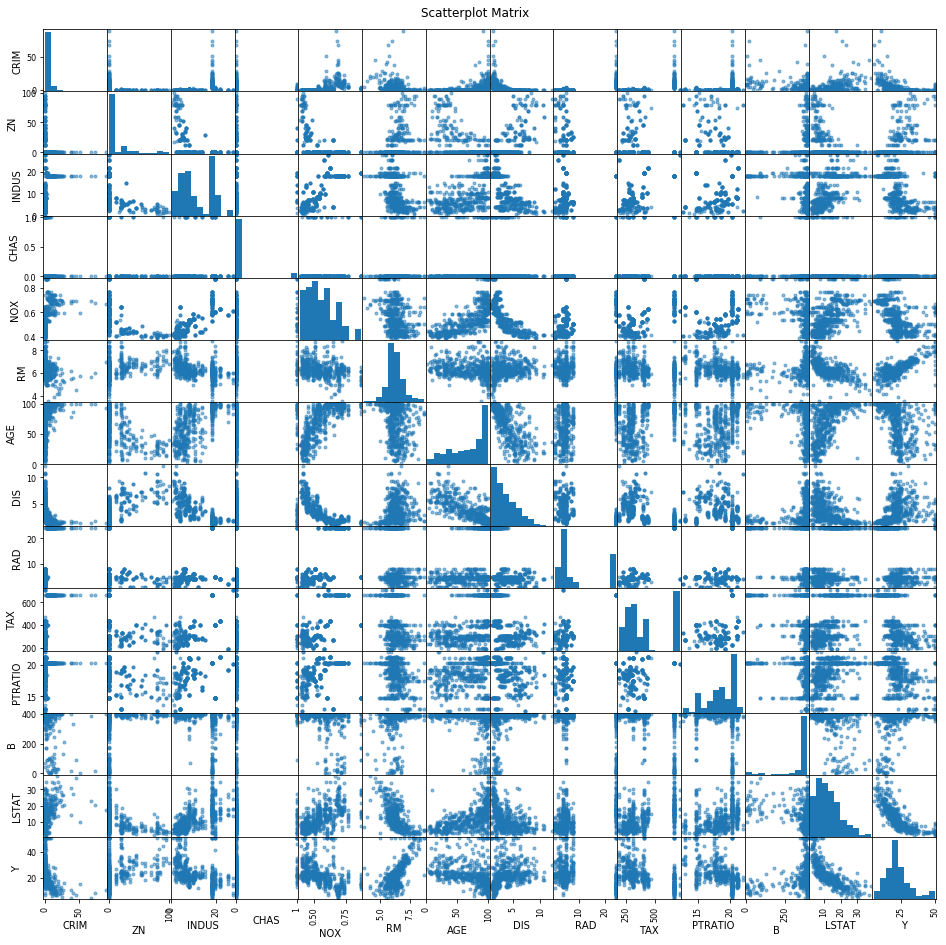

In [4]:
plt.close("all")
scatter_matrix = pd.tools.plotting.scatter_matrix(df, figsize=(16,16))
plt.suptitle('Scatterplot Matrix', y=0.9)
plt.show()

From the dataset description and scatterplot matrix above, we can find that CHAS is a categorical variable. We can do a trick check:

In [5]:
df.apply(lambda x: len(set(x)))

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
Y          229
dtype: int64

Attention that RAD(index of accessibility to radial highways) is a variable with 9 levels, but we can treat it as a numeric one.

## Split the dataset

Consider cross-validation, we should split the dataset into training part and validation part. We can use `train_test_split` from `sklearn`, or manually shuffle the original dataset and split it. 

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(df.drop("Y", axis=1), df.Y, test_size=0.33, random_state=123)
x_train.shape, x_valid.shape

((339, 13), (167, 13))

## Response Variable Exploration

For a linear regression model, the error term is assumed to be Normal distributed (if we want to do further test and ANOVA work). So the distribution of the response variable (of the traning set) should be Normal-like.

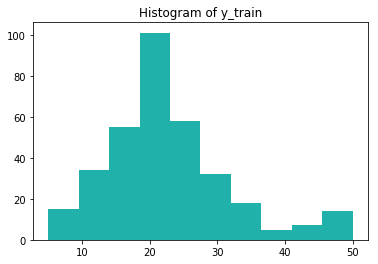

In [7]:
plt.close("all")
_ = plt.hist(y_train, color="LightSeaGreen")
plt.title("Histogram of y_train")
plt.show()

From figure above, we find that the response variable is skewed. A boxcox:

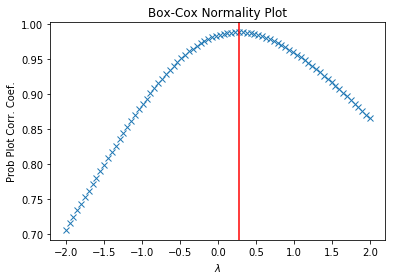

In [8]:
from scipy import stats

plt.close("all")
fig, ax = plt.subplots()
_ = stats.boxcox_normplot(y_train, -2, 2, plot=ax)  # Only consider lambda in [-2, 2]
y_train_boxcox, maxlog = stats.boxcox(y_train)
ax.axvline(maxlog, color="r")
plt.show()

Check the value after transformation:

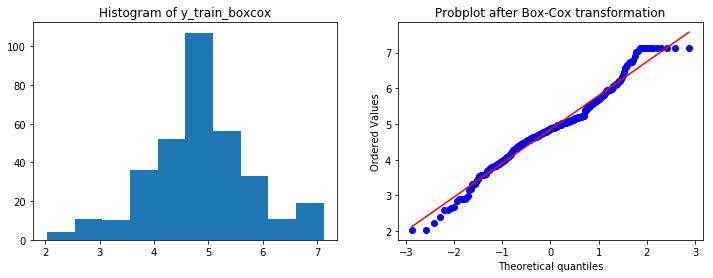

In [9]:
plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of Y after transformation
_ = ax1.hist(y_train_boxcox)
ax1.set_title("Histogram of y_train_boxcox")

# Comparision of quantiles from Normal distr. and Y
_ = stats.probplot(y_train_boxcox, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## Regression

Now we can start linear regression with oridnary least square (OLS) principle.

In [10]:
# Convert y_train_boxcox from NdArray into Series
y_train_boxcox = pd.Series(y_train_boxcox, name="Y")

# OLS linear regression model
model = smf.ols("Y ~" + "+".join(x_train.columns), 
                data=pd.concat([x_train, y_train_boxcox], axis="columns")).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.526
Date:                Thu, 23 Nov 2017   Prob (F-statistic):              0.109
Time:                        03:58:11   Log-Likelihood:                -307.14
No. Observations:                 234   AIC:                             642.3
Df Residuals:                     220   BIC:                             690.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8366      1.855      1.529      0.128      -0.818       6.492
CRIM          -0.1956      0.177     -1.105      0.270      -0.544       0.153
ZN             0.0039      0.004      1.065      0.288      -0.003       0.011
INDUS         -0.0065      0.016     -0.401      0.689      -0.038       0.025
CHAS          -0.2195      0.249     -0.882      0.379      -0.710       0.271
NOX            3.5267      1.446      2.439      0.016       0.677       6.376
RM            -0.0568      0.135     -0.422      0.674      -0.322       0.209
AGE           -0.0084      0.003     -2.469      0.014      -0.015      -0.002
DIS            0.0311      0.057      0.546      0.585      -0.081       0.143
RAD            0.0251      0.042      0.597      0.551      -0.058       0.108
TAX            0.0002      0.001      0.142      0.887      -0.002       0.002
PTRATIO       -0.0160      0.036     -0.448      0.655      -0.086       0.054
B              0.0026      0.002      1.116      0.266      -0.002       0.007
LSTAT          0.0193      0.017      1.109      0.269      -0.015       0.054
==============================================================================
Omnibus:                        1.718   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.384
Skew:                           0.156   Prob(JB):                        0.501
Kurtosis:                       3.210   Cond. No.                     1.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(To be continued)